#### Import library

In [22]:
import joblib
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import string
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

#### Process data

In [2]:
def text_process(data):
    '''
    1. remove punc
    2. do stemming of words
    3. remove stop words
    4. return list of clean text words
    '''
    nopunc = [c for c in data if c not in string.punctuation] #remove punctuations
    nopunc = ''.join(nopunc)
    
    stemmed = ''
    nopunc = nopunc.split()
    for i in nopunc:
        stemmer = SnowballStemmer('english')
        stemmed += (stemmer.stem(i)) + ' ' # stemming of words
        
    clean_msgs = [word for word in stemmed.split() if word.lower() not in stopwords.words('english')] # remove stopwords
    clean_msgs = ' '.join(i for i in clean_msgs)
    
    return clean_msgs

#### Report function

In [25]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def report(y_true, y_pred, y_scores=None):
    # In các chỉ số cơ bản
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    # Vẽ ROC Curve nếu y_scores được cung cấp
    if y_scores is not None:
        # Tính các giá trị cho ROC
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        
        # Vẽ đồ thị
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

#### Read data

In [5]:
def loadData():
    data_path='D:\\1\\'
    data = pd.read_csv(data_path+'5000 YT comments.csv', encoding='latin1')
    data = data.drop(['Name', 'Time', 'Likes', 'Reply Count'], axis=1)
    data['Comment'] = data['Comment'].apply(text_process)
    
    return data

# load data
data = loadData()

#### Vectorize and train test split

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=3700)
X = vectorizer.fit_transform(data['Comment'])

In [15]:
X_matrix = X.toarray()

In [16]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X_matrix, data['Spam'], test_size=0.3, random_state=101)

In [17]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

In [18]:
X_train.shape

(3500, 3700)

In [19]:
X_test.shape

(1500, 3700)

#### SVM from scratch

In [27]:
import numpy as np
import matplotlib.pyplot as plt

class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000, print_every=100, kernel='linear', sigma=1.0):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.print_every = print_every
        self.kernel_type = kernel
        self.sigma = sigma
        self.alpha = None
        self.b = 0
        self.X = None
        self.y = None
        self.losses = []

    def _kernel(self, X1, X2):
        if self.kernel_type == 'linear':
            return np.dot(X1, X2.T)
        elif self.kernel_type == 'rbf':
            if X1.ndim == 1 and X2.ndim == 1:
                return np.exp(-np.linalg.norm(X1 - X2) ** 2 / (2 * (self.sigma ** 2)))
            elif X1.ndim > 1 and X2.ndim > 1:
                K = np.zeros((X1.shape[0], X2.shape[0]))
                for i in range(X1.shape[0]):
                    for j in range(X2.shape[0]):
                        K[i, j] = np.exp(-np.linalg.norm(X1[i] - X2[j]) ** 2 / (2 * (self.sigma ** 2)))
                return K
            else:
                return np.exp(-np.linalg.norm(X1 - X2) ** 2 / (2 * (self.sigma ** 2)))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.alpha = np.zeros(n_samples)
        self.b = 0
        self.X = X
        self.y = np.where(y <= 0, -1, 1)

        for iteration in range(self.n_iters):
            for i in range(n_samples):
                condition = self.y[i] * (np.sum(self.alpha * self.y * self._kernel(self.X, self.X[i])) + self.b) >= 1
                if condition:
                    self.alpha[i] -= self.lr * (2 * self.lambda_param * self.alpha[i])
                else:
                    self.alpha[i] += self.lr * (1 - self.y[i] * (np.sum(self.alpha * self.y * self._kernel(self.X, self.X[i])) + self.b))

            if iteration % self.print_every == 0:
                loss = self.calculate_loss()
                self.losses.append(loss)
                print(f'Iteration {iteration}, loss: {loss}')

    def calculate_loss(self):
        distances = 1 - self.y * (np.dot(self.alpha * self.y, self._kernel(self.X, self.X)) + self.b)
        distances[distances < 0] = 0
        hinge_loss = np.mean(distances)
        reg_loss = self.lambda_param * np.sum(self.alpha ** 2)
        return hinge_loss + reg_loss

    def predict(self, X):
        y_predict = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            prediction = np.sum(self.alpha * self.y * self._kernel(self.X, X[i])) + self.b
            y_predict[i] = np.sign(prediction)
        return y_predict

    def plot_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(0, self.n_iters, self.print_every), self.losses, marker='o')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Loss over iterations')
        plt.show()


Iteration 0, loss: 0.9756606877861956
Iteration 10, loss: 0.8450102515807426
Iteration 20, loss: 0.8231872680689121
Iteration 30, loss: 0.8762218226552829
Iteration 40, loss: 1.0024712382841585
Iteration 50, loss: 1.2006275356699985
Iteration 60, loss: 1.469784246807583
Iteration 70, loss: 1.807710004031617
Iteration 80, loss: 2.214328028478506
Iteration 90, loss: 2.6885772617906034
Iteration 100, loss: 3.230624275805023
Iteration 110, loss: 3.839984326930827
Iteration 120, loss: 4.511205896345487
Iteration 130, loss: 5.243010268230632
Iteration 140, loss: 6.034745224502759
Iteration 150, loss: 6.886068212711121
Iteration 160, loss: 7.796732540737737
Iteration 170, loss: 8.766640339036307
Iteration 180, loss: 9.795669232871465
Iteration 190, loss: 10.883769052929658
Iteration 200, loss: 12.030996209981659
Iteration 210, loss: 13.237294784994567
Iteration 220, loss: 14.502610959203608
Iteration 230, loss: 15.826876582421857
Iteration 240, loss: 17.210079265471084
Iteration 250, loss: 18

C:\Users\admin\AppData\Local\Temp\ipykernel_14792\2790964246.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.mean(predictions == np.where(y_test <= 0, -1, 1))


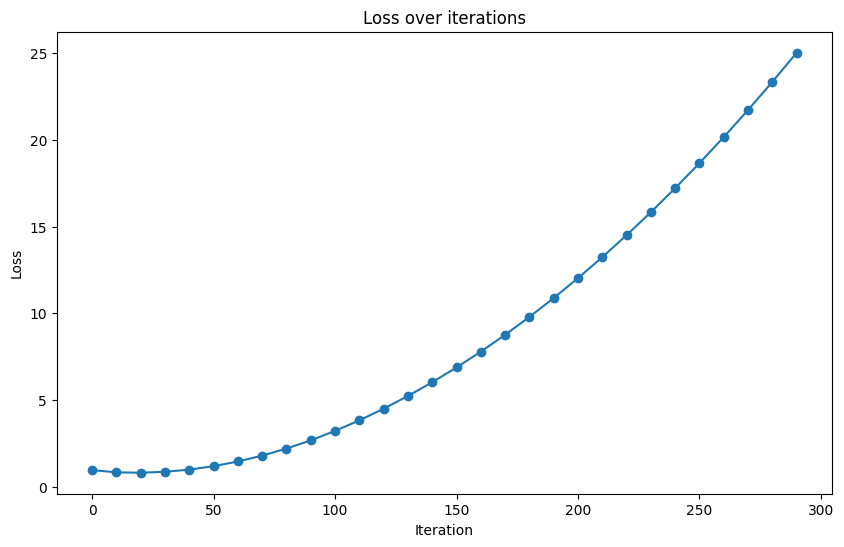

In [30]:
svm = SVM(learning_rate=0.005, lambda_param=0.01, n_iters=300, print_every=10, kernel='rbf', sigma=0.5)
svm.fit(X_train, y_train)
predictions = svm.predict(X_val)

# Đánh giá mô hình
accuracy = np.mean(predictions == np.where(y_test <= 0, -1, 1))
print(f"Accuracy with RBF kernel: {accuracy}")

# Vẽ đồ thị cho RBF kernel
svm.plot_loss()

In [ ]:
svm_linear = SVM(learning_rate=0.05, lambda_param=0.01, n_iters=1000, print_every=1, kernel='linear')
svm_linear.fit(X_train, y_train)
predictions_linear = svm_linear.predict(X_val)

# Đánh giá mô hình
accuracy_linear = np.mean(predictions_linear == np.where(y_test <= 0, -1, 1))
print(f"Accuracy with Linear kernel: {accuracy_linear}")

# Vẽ đồ thị cho Linear kernel
svm_linear.plot_loss()

#### SVM sử dụng thư viện

In [20]:
# Linear
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


param_grid = {'C': [0.1, 1, 5, 10], 'gamma': [0.01, 0.1, 1, 10]}

# thực hiện grid search
grid_search = GridSearchCV(SVC(kernel='linear'), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# in ra best params
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'C': 1, 'gamma': 0.01}
Best Score: 0.8785714285714284


Accuracy: 0.8946666666666667
Confusion Matrix:
 [[680  80]
 [ 78 662]]


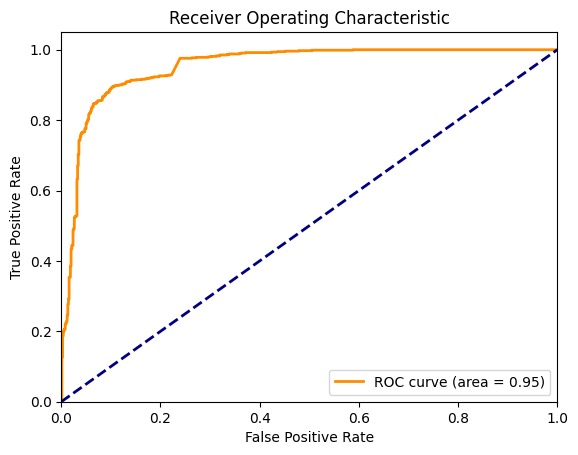

In [27]:
svc_linear_best_model = grid_search.best_estimator_

# đánh giá model
y_pred = svc_linear_best_model.predict(X_test)
y_prob = svc_linear_best_model.decision_function(X_test)
report(y_test, y_pred, y_prob)

In [28]:
# Non-linear

# Define the grid of parameters to search
param_grid = {'C': [0.1, 1, 5, 10], 'gamma': [0.01, 0.1, 1, 10]}

# Perform grid search
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'C': 1, 'gamma': 1}
Best Score: 0.884


Accuracy: 0.912
Confusion Matrix:
 [[680  80]
 [ 52 688]]


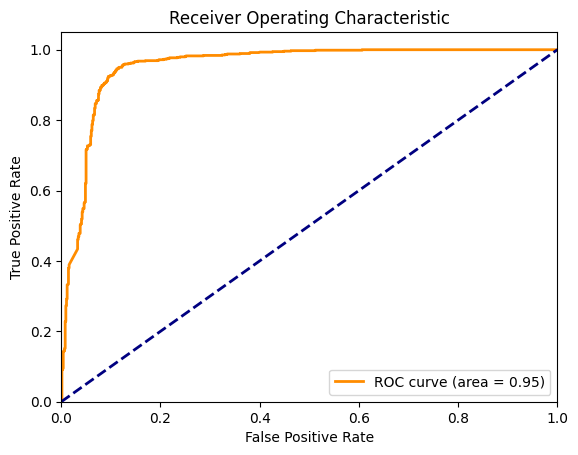

In [29]:
svc_rbf_best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred = svc_rbf_best_model.predict(X_test)
y_prob = svc_rbf_best_model.decision_function(X_test)
report(y_test, y_pred, y_prob)

#### Lưu lại model và load model

In [31]:
import joblib

# Lưu mô hình đã được huấn luyện
joblib.dump(svc_rbf_best_model, 'svm_rbf_model.pkl')

['svm_rbf_model.pkl']

In [33]:
# Tải mô hình
loaded_model = joblib.load('svm_rbf_model.pkl')

# Dùng mô hình đã tải để dự đoán
y_pred = loaded_model.predict(X_test)
print("Predictions using loaded model:", y_pred)

Predictions using loaded model: [1 1 1 ... 0 1 1]


#### Phần quan trọng (load model)

#### Random Forest dùng thư viện

In [37]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [38]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
410 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\bas

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [40]:
best_rf = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

y_pred = best_rf.predict(X_test)
print("Accuracy on test set: {:.2f}".format(accuracy_score(y_test, y_pred)))

report(y_test, y_pred)


Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.82
Accuracy on test set: 0.84
Accuracy: 0.836
Confusion Matrix:
 [[696  64]
 [182 558]]


#### Lưu và load model

In [41]:
import joblib

# Lưu mô hình đã được huấn luyện
joblib.dump(best_rf, 'random_forest.pkl')

['random_forest.pkl']

In [42]:
# Tải mô hình
loaded_model = joblib.load('random_forest.pkl')

# Dùng mô hình đã tải để dự đoán
y_pred = loaded_model.predict(X_test)
print("Predictions using loaded model:", y_pred)

Predictions using loaded model: [1 1 1 ... 0 1 1]


### Final

In [3]:
# import thư viện

import joblib
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import string
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [4]:
def text_process(data):
    '''
    1. remove punc
    2. do stemming of words
    3. remove stop words
    4. return list of clean text words
    '''
    nopunc = [c for c in data if c not in string.punctuation] #remove punctuations
    nopunc = ''.join(nopunc)
    
    stemmed = ''
    nopunc = nopunc.split()
    for i in nopunc:
        stemmer = SnowballStemmer('english')
        stemmed += (stemmer.stem(i)) + ' ' # stemming of words
        
    clean_msgs = [word for word in stemmed.split() if word.lower() not in stopwords.words('english')] # remove stopwords
    clean_msgs = ' '.join(i for i in clean_msgs)
    
    return clean_msgs

In [5]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def report(y_true, y_pred, y_scores=None):
    # In các chỉ số cơ bản
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    # Vẽ ROC Curve nếu y_scores được cung cấp
    if y_scores is not None:
        # Tính các giá trị cho ROC
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        
        # Vẽ đồ thị
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

In [6]:
def loadData():
    data_path='D:\\1\\'
    data = pd.read_csv(data_path+'5000 YT comments.csv', encoding='latin1')
    data = data.drop(['Name', 'Time', 'Likes', 'Reply Count'], axis=1)
    data['Comment'] = data['Comment'].apply(text_process)
    
    return data

# load data
data = loadData()

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=3700)
X = vectorizer.fit_transform(data['Comment'])
X_matrix = X.toarray()

In [17]:
# Tải mô hình
import joblib
random_forest = joblib.load('random_forest.pkl')

svm_model = joblib.load('svm_rbf_model.pkl')

In [18]:
random_forest

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [19]:
svm_model

SVC(C=1, gamma=1)

In [20]:
# predict
y_rf_pred = random_forest.predict(X_matrix)
report(data['Spam'], y_rf_pred)

Accuracy: 0.8438
Confusion Matrix:
 [[2353  147]
 [ 634 1866]]


In [21]:
# predict
y_svm_pred = svm_model.predict(X_matrix)
report(data['Spam'], y_svm_pred)

Accuracy: 0.9508
Confusion Matrix:
 [[2318  182]
 [  64 2436]]
